# AidSDK部署-摄像头实时预测

同济子豪兄 2023-8-19 9-1 9-4

## 导入工具包

In [1]:
import cv2
from cvs import *

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

## AidLite初始化

In [2]:
import aidlite_gpu
aidlite = aidlite_gpu.aidlite()

[2023-09-16 17:46:44,053228][/tmp/ipykernel_23557/1811969939.py:2 <module>][DEBUG]:=======init


## 载入TFLite模型

In [3]:
model_path = 'mmseg2onnx_fastscnn_static_aimo_tflite/end2end_fp32.tflite'

In [4]:
# 文档：https://docs.aidlux.com/#/intro/ai/ai-aidlite?id=_4fast_annmodel

aidlite.FAST_ANNModel(
    model_path,           # 模型路径
    [1*1024*2048*3*4],    # 输入维度：Batch H W C 字节数
    [1*1024*2048*1*8],    # 输出维度：Batch H W C 字节数
    numberOfThreads=3,    # 加载数据和模型所需要的核数
    enableNNAPI=0         # 是否开启NNAPI
)

Result(id=1, result='load model ok!', error=None)

## 可视化配置

In [5]:
palette = [
    ['background', [127,127,127]],
    ['red', [0,0,200]],
    ['green', [0,200,0]],
    ['white', [144,238,144]],
    ['seed-black', [30,30,30]],
    ['seed-white', [8,189,251]]
]

palette_dict = {}
for idx, each in enumerate(palette):
    palette_dict[idx] = each[1]

In [6]:
palette_dict

{0: [127, 127, 127],
 1: [0, 0, 200],
 2: [0, 200, 0],
 3: [144, 238, 144],
 4: [30, 30, 30],
 5: [8, 189, 251]}

## 逐帧处理函数

In [7]:
opacity = 0.3 # 透明度，越大越接近原图

In [8]:
def process_frame(img_bgr, camera=True):
    
    '''
    输入摄像头画面 bgr-array，输出图像 bgr-array
    '''
    
    # 记录该帧开始处理的时间
    start_time = time.time()
    
    if camera: # 对于摄像头实时预测，将手机拍摄到的竖屏图像旋转90度，变成横屏图像
        img_bgr = cv2.rotate(img_bgr, cv2.ROTATE_90_CLOCKWISE)
    
    # 从原图中裁剪出高宽比1:2的最大图像
    h, w = img_bgr.shape[0], img_bgr.shape[1]
    new_h = w // 2 # 横屏图片，截取一半的宽度，作为新的高度
    img_bgr_crop = img_bgr[0:new_h, :]
    
    # 缩放至模型要求的高1024 x 宽2048像素
    img_bgr_resize = cv2.resize(img_bgr_crop, (2048, 1024)) # 缩放尺寸
    
    # 预处理
    img_rgb_resize = cv2.cvtColor(img_bgr_resize, cv2.COLOR_BGR2RGB) # BGR 转 RGB
    mean = (0.485, 0.456, 0.406) # 三通道的均值
    std = (0.229, 0.224, 0.225) # 三通道的标准差
    img_tensor = ((img_rgb_resize / 255) - mean) / std # 归一化
    img_tensor = img_tensor.astype('float32')
    
    # 推理预测
    aidlite.setInput_Float32(img_tensor) # 装填数据
    aidlite.invoke() # 推理预测
    output = aidlite.getOutput_Float32() # 获得模型输出结果
    output_bytes = output.tobytes() # 将模型输出结果转 bytes
    pred_mask = np.frombuffer(output_bytes, dtype=np.int64).reshape(1024, 2048) # 再转 int64

    # 将预测的整数ID，映射为对应类别的颜色
    pred_mask_bgr = np.zeros((pred_mask.shape[0], pred_mask.shape[1], 3))
    for idx in palette_dict.keys():
        pred_mask_bgr[np.where(pred_mask==idx)] = palette_dict[idx]
    pred_mask_bgr = pred_mask_bgr.astype('uint8')

    # 将语义分割预测图和原图叠加显示
    pred_viz = cv2.addWeighted(img_bgr_resize, opacity, pred_mask_bgr, 1-opacity, 0)
    
    img_bgr = pred_viz
    
    if camera: # 对于摄像头实时预测，缩放并旋转至竖屏，便于手机屏幕上显示
        img_bgr = cv2.resize(img_bgr, (640, 320)) # 缩放尺寸
        img_bgr = cv2.rotate(img_bgr, cv2.ROTATE_90_COUNTERCLOCKWISE)
    else: # 对于视频预测
        img_bgr = cv2.resize(img_bgr, (w, h)) # 缩放尺寸
    
    # 记录该帧处理完毕的时间
    end_time = time.time()
    # 计算每秒处理图像帧数FPS
    FPS = 1/(end_time - start_time)
    # 在画面上写字：图片，字符串，左上角坐标，字体，字体大小，颜色，字体粗细
    scaler = 1 # 文字大小
    FPS_string = 'FPS {:.2f}'.format(FPS) # 写在画面上的字符串
    img_bgr = cv2.putText(img_bgr, FPS_string, (25 * scaler, 60 * scaler), cv2.FONT_HERSHEY_SIMPLEX, 1.25 * scaler, (255, 0, 255), 2 * scaler)
    
    return img_bgr

## 初始化摄像头

In [9]:
# 摄像头ID 0-后置 1-前置
Camera_ID = 0

In [10]:
cap = cvs.VideoCapture(Camera_ID)

('app runs on port:', 39337)
open the cam:0 ...


remi.server      INFO     Started httpserver http://0.0.0.0:39337/
remi.request     INFO     built UI (path=/)
remi.server.ws   INFO     connection established: ('192.168.1.5', 51209)
remi.server.ws   INFO     handshake complete
remi.server.ws   INFO     connection established: ('127.0.0.1', 57946)
remi.server.ws   INFO     handshake complete
remi.request     ERROR    sending websocket spontaneous message
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/remi/server.py", line 497, in _send_spontaneous_websocket_message
    if ws.send_message(message):
  File "/usr/local/lib/python3.7/dist-packages/remi/server.py", line 209, in send_message
    self.request.sendall(out)
BrokenPipeError: [Errno 32] Broken pipe
remi.server.ws   ERROR    exception in WebSocketsHandler.close method
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/remi/server.py", line 279, in close
    self.request.shutdown(socket.SHUT_RDWR)
OSError: [Errno 10

## 调用摄像头获取一帧画面

In [24]:
img_bgr = cap.read()

In [25]:
img_bgr.shape

(640, 480, 3)

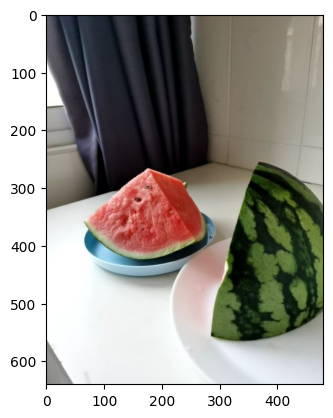

In [26]:
plt.imshow(img_bgr[:,:,::-1])
plt.show()

## 单帧画面语义分割预测

In [27]:
img_bgr = process_frame(img_bgr)

In [28]:
img_bgr.shape

(640, 320, 3)

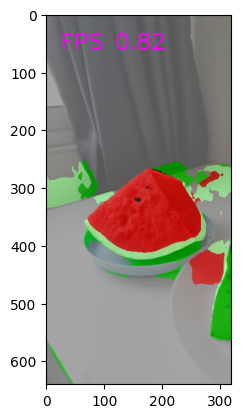

In [29]:
plt.imshow(img_bgr[:,:,::-1])
plt.show()

In [30]:
cvs.imshow(img_bgr)

## 逐帧实时处理手机摄像头拍摄的画面-代码模板

In [ ]:
while True:
    img_bgr = cap.read()
    
    if img_bgr is None:
        continue
        
    img_bgr = process_frame(img_bgr, camera=True)
    
    cvs.imshow(img_bgr)

> 点击重启`kernel`关闭摄像头

## 视频逐帧处理（模板）

In [9]:
import cv2
import numpy as np
import time
from tqdm import tqdm

# 视频逐帧处理代码模板
# 不需修改任何代码，只需定义process_frame函数即可
# 同济子豪兄 2021-7-10

def generate_video(input_path='videos/robot.mp4'):
    filehead = input_path.split('/')[-1]
    output_path = "out-" + filehead
    
    print('视频开始处理',input_path)
    
    # 获取视频总帧数
    cap = cv2.VideoCapture(input_path)
    frame_count = 0
    while(cap.isOpened()):
        success, frame = cap.read()
        frame_count += 1
        if not success:
            break
    cap.release()
    print('视频总帧数为',frame_count)
    
    # cv2.namedWindow('Crack Detection and Measurement Video Processing')
    cap = cv2.VideoCapture(input_path)
    frame_size = (cap.get(cv2.CAP_PROP_FRAME_WIDTH), cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # fourcc = int(cap.get(cv2.CAP_PROP_FOURCC))
    # fourcc = cv2.VideoWriter_fourcc(*'XVID')
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    fps = cap.get(cv2.CAP_PROP_FPS)

    out = cv2.VideoWriter(output_path, fourcc, fps, (int(frame_size[0]), int(frame_size[1])))
    
    # 进度条绑定视频总帧数
    with tqdm(total=frame_count-1) as pbar:
        try:
            while(cap.isOpened()):
                success, frame = cap.read()
                if not success:
                    break

                # 处理帧
                # frame_path = './temp_frame.png'
                # cv2.imwrite(frame_path, frame)
                try:
                    frame = process_frame(frame, camera=False)
                except:
                    print('报错！', error)
                    pass
                
                if success == True:
                    # cv2.imshow('Video Processing', frame)
                    out.write(frame)

                    # 进度条更新一帧
                    pbar.update(1)

                # if cv2.waitKey(1) & 0xFF == ord('q'):
                    # break
        except:
            print('中途中断')
            pass

    cv2.destroyAllWindows()
    out.release()
    cap.release()
    print('视频已保存', output_path)

In [ ]:
generate_video(input_path='video_watermelon_3.mov')

视频开始处理 video_watermelon_3.mov
视频总帧数为 175


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 124/174 [03:33<01:44,  2.10s/it]